In [1]:
## Goals
# Computer experiments: 
# Rate-state friction with spring-slider;
# Transients and limit cycles
# Stick slip earthquake sequences.
import numpy    as     np
import ode      as odeLib        # our ODE routines
import matplotlib.pyplot as plt
from   scipy import integrate

The rate- and state friction is described by the following governing equations in general:

\begin{align}
\tau = F[V, \theta_1, \theta_2, ... ] \\
\dot \theta_1 = G_1[V, \theta_1, \theta_2, ...] \\ 
\dot \theta_2 = G_2[V, \theta_1, \theta_2, ...] \\ 
...
\end{align}

The simpliest form of interaction between the rate and state friction and elastic deformation is described by the one degree spring-slider system governed by the rate and state friction. Following Gu et al. (1984), the governing equations are 

\begin{align}
df / dT = \kappa (v_0 - e^\phi) \\
d \phi / dT = e^\phi (-\kappa + f + \lambda \phi) + \kappa v_0  \\
\end{align}

where dimensionaless quantities $f$ is frictional stress ($\tau - \tau_*)/A$, $\phi$ is logarithmic velocity measure $ln(V/V_*)$, and $\Theta$ is state variable $\theta/A$, $\kappa = kL/A$ and $v_0 = V_0/V_*$.

In [2]:
# Solve an elastic spring-slider system governed by the rate and state friction.
# A numerical implementation of Gu et al. (1984).

# define parameters for the rate- and state- friction system.
class parameters: 
    a       = 0.01
    b       = 0.015
    Dc      = 0.04
    v0      = 1.e-6
    f0      = 0.6
    sigmaN  = 25.e6
    beta    = 1.5
    plambda  = beta - 1.
    loadMode= 'step'

# define the ODEs for the system.
# 
def f0(t,x,par):         # df/dT = kappa(v0-expPhi), eq 14a in Gu et al.(1984). 
    # x[0]: f
    # x[1]: phi
    phi     = x[1]
    kappa   = par.kappa
    expPhi  = np.exp(phi) 
    mode    = par.loadMode
    v0      = loadHist(t, mode)
    
    return kappa * (v0 - expPhi)

def f1(t,x,par):         # dphi/dT = exp(phi)*(-kappa + f + lambda*phi) + kappa*v0, eq 14b in Gu et al.(1984). 
    kappa   = par.kappa
    f       = x[0]
    phi     = x[1]
    plambda  = par.plambda
    expPhi  = np.exp(phi)
    mode    = par.loadMode
    v0      = loadHist(t, mode)
    
    return  expPhi*(-kappa + f + plambda*phi) + kappa*v0

def f2(t,x,par):         # d_d/dT.
    mode    = par.loadMode
    v0      = loadHist(t, mode)
    return v0 

# loadHist defines the loading (velocity) profiles for the whole time series.
# various experiments are defined by the parameter mode. 
def loadHist(t, mode):
    v           = 0
    if mode   == 'step':
        if t   < 0: 
            v   = 1
        elif t < 1:
            v   = 10
        else:
            v   = 1
    elif mode == 'hold':
        v       = 1

    return v 

# The solver of the rsf ODE system.
def rsfOdeSolver(time, xInit, method, ndim, par):
    # following the equation 14 in Gu et al. (1984).
    # dimensionless variables f, phi, and Theta
    nstep = len(time)
    xout  = np.empty((nstep,ndim))
    
    hs    = time[1] - time[0]
    xtmp  = xInit
    func  = [f0, f1, f2]
    
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,func,ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,func,ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,func,ndim,hs,par)
    f     = xout[:,0]
    phi   = xout[:,1]
    disp  = xout[:,2]
    
    return f, phi, disp

Text(0, 0.5, 'f')

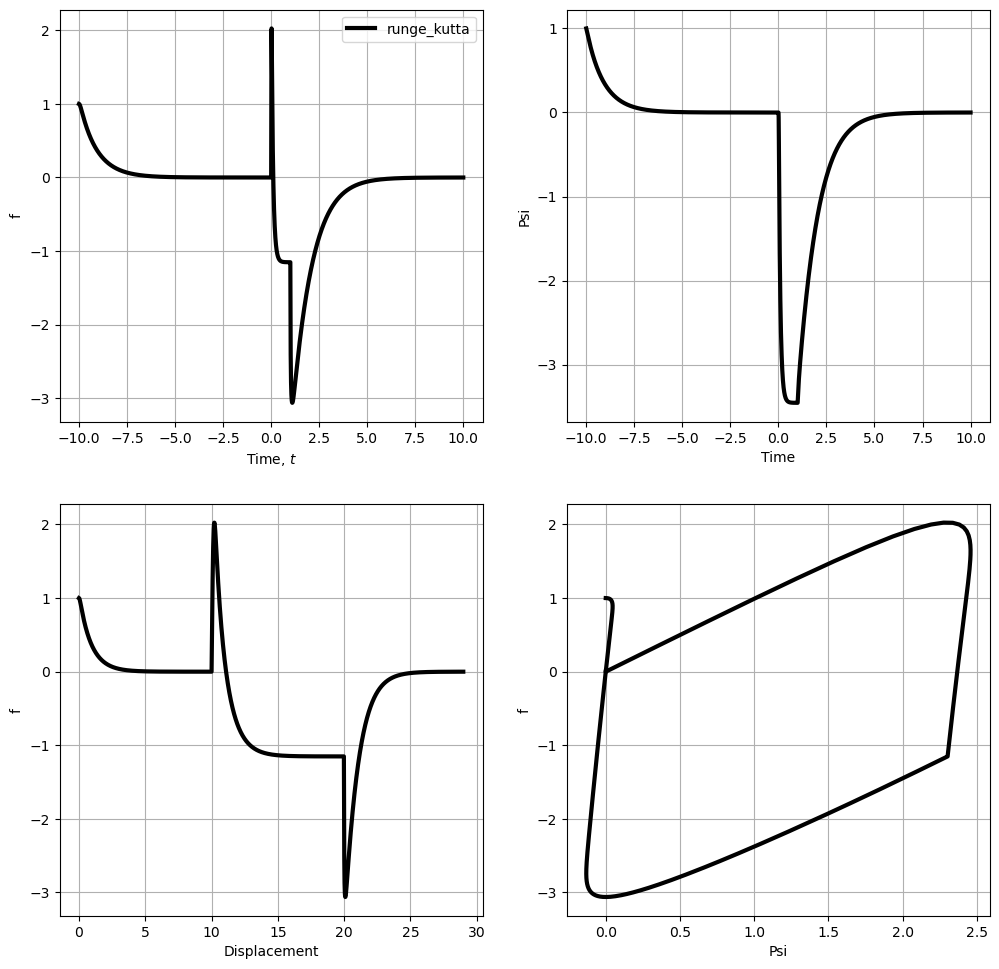

In [3]:
par       = parameters()
par.loadMode = 'step'
Nt        = 10000
t         = np.linspace(-10., 10., Nt)
kappa_fac = 40
ndim      = 3
par.kappa = par.plambda * kappa_fac


# Method 1, Runge_Kutta
xInit     = [1., 0., 0.]
f, phi, d = rsfOdeSolver(t, xInit, 'runge_kutta', ndim, par)

fig       = plt.figure(figsize=(12,12), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(2,2,1)
plt.plot(t, f, 'k',    label='runge_kutta',       linewidth=3)
plt.grid()
plt.xlabel("Time, $t$")
plt.ylabel("f")
plt.legend()

plt.subplot(2,2,2)
plt.plot(t, f - phi, 'k',  label='runge_kutta',       linewidth=3)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Psi")

plt.subplot(2,2,3)
plt.grid()
plt.plot(d, f, 'k',    label='runge_kutta',       linewidth=3)
plt.xlabel("Displacement")
plt.ylabel("f")
           
plt.subplot(2,2,4)
plt.grid()
plt.plot(phi, f, 'k',  label='runge_kutta',       linewidth=3)
plt.xlabel("Psi")
plt.ylabel("f")

Keep for later use.
Quasi-dynamic formulation:
\begin{align}
F(v, \theta) = \tau_0 - \eta v \\
\dot \theta = 1 - v \theta / D_c
\end{align}

Dynamic formulation:
\begin{align}
F(v, \theta) = \tau_0 - m \dot v \\
\dot \theta = 1 - v \theta / D_c
\end{align}

In [4]:
# Other implementations. For later use.
# define rate- and state friction solver
def rsfReg(v, state, par):
    a       = par.a
    b       = par.b
    Dc      = par.Dc
    v0      = par.v0
    f0      = par.f0
    
    f       = a * np.arcsinh(v/(2.*v0)* np.exp((f0 + b*np.log(v*state/Dc))/a))
    
    return f

def agingLaw(v, state, par):
    Dc      = par.Dc
    return  (1. - v*state/Dc)

def dynamic(xInit, time, tau, sigmaN, rho, par):
    v       = xInit[0]
    state   = xInit[1]
    f0      = (tau - sigmaN*rsfReg(v, state, par))/rho
    f1      = agingLaw(v, state, par)
    return [f0, f1]
def quasiDynamic(xInit, time, tau, sigmaN, rho, par):
    return tau